In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt


from scipy.optimize import broyden1

from edpyt.shared import params
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
# new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/production_run'
# os.chdir(new_path)

In [3]:
class Sigma:
    def __init__(self, gf0, gf, H_eff, eta=1e-5):
        self.gf0 = gf0
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g0 = self.gf0(energies, self.eta)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = np.linalg.inv(g0[..., e]) - np.linalg.inv(g[..., e])
        return sigma


class Sigma2:
    '''
    This method of computing self-energy gives the wrong off-diagonal elements
    '''
    def __init__(self, gf, H_eff, eta=1e-5):
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size,self.gf.n,self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = energy - self.H_eff - np.linalg.inv(g[...,e])
        return sigma


def residual_function(dc_diag):
    # Clip only the lower bound
    dc_diag = np.clip(dc_diag, 0.0, np.inf)

    DC = np.diag(dc_diag)
    espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
    screen_espace(espace, egs, beta)
    gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
    sigma = Sigma( gf, H_eff, eta=eta)

    # Get physical residual from Σ at large negative frequency
    energies = np.array([-1.0])
    sig_cost = sigma.retarded(energies)
    sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
    residual = np.sum(sig_real_diag, axis=0)

    # Logging
    residual_norm = np.linalg.norm(residual)
    print(f"[Broyden] Residual norm: {residual_norm:.6e}, DC_diag: {dc_diag}")

    return residual

In [4]:
# === Load inputs ===
input_folder = "./output/lowdin"
output_folder = "./output/lowdin/ed"
os.makedirs(output_folder, exist_ok=True)
sigma_ref = np.load("../reference/sigma_ed.npy")
np.round(sigma_ref[0],5)

H_eff = np.load(f"{input_folder}/effective_hamiltonian.npy")
occupancy_goal = np.load(f"{input_folder}/occupancies.npy")
V = np.loadtxt(f"{input_folder}/U_matrix.txt")

# === Parameters ===
nimp = H_eff.shape[0]
eta = 1e-2
beta = 1000

de = 0.01
energies = np.arange(-100, 100 + de / 2.0, de).round(7)

neig = np.ones((nimp + 1) * (nimp + 1), int) * 6
params["z"] = occupancy_goal

# === Initial double counting ===
DC0 = np.diag(V.diagonal() * (occupancy_goal - 0.5))
dc0_diag = DC0.diagonal()
# x0 = dc0_diag.copy()

dc0_diag

array([5.46515887, 1.97886514, 2.52035611, 2.22202704, 2.7152016 ,
       2.12250731, 5.90703705])

In [5]:
espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
screen_espace(espace, egs, beta)
gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)

In [6]:
espace, egs = build_espace(H_eff - DC0, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC0, V, espace, beta, egs)
sigma = Sigma(gf0,gf, H_eff, eta=eta)
sigma_ret = sigma.retarded(energies)
np.save(f"{output_folder}/sigma_abinit.npy", sigma_ret)


(1.8239861998653595-1.417265768425581e-05j)
(2.0977335700042943-1.3841305334084952e-05j)


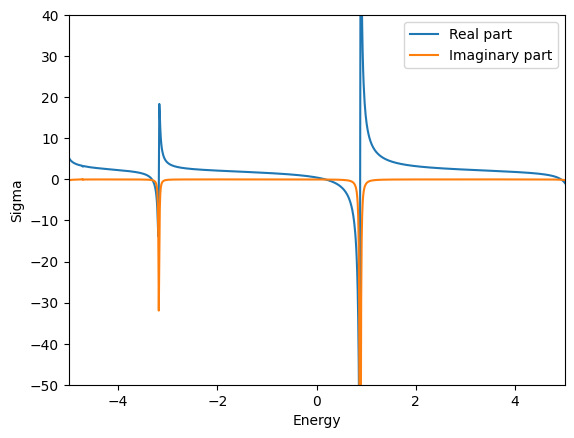

In [7]:
sigma_ret = np.load(f"{output_folder}/sigma_abinit.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-5,5)
plt.ylim(-50,40)
plt.legend()
print(sigma_ret_trace[0])
print(sigma_ret_trace[-1])

## Optimized self-energy

In [ ]:
# dc_diag_optimized = np.load(f"{output_folder}/ed_dcc_diag.npy")
# DC = np.diag(dc_diag_optimized)
# espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
# screen_espace(espace, egs, beta)
# gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
# sigma = Sigma( gf0, gf, H_eff, eta=eta)
# sigma_ret = sigma.retarded(energies)
# np.save(f"{output_folder}/sigma_optimized.npy",sigma_ret)

(-0.1378283120381809-4.4425609226492885e-05j)
(0.14300505805418595-4.175470586025368e-05j)


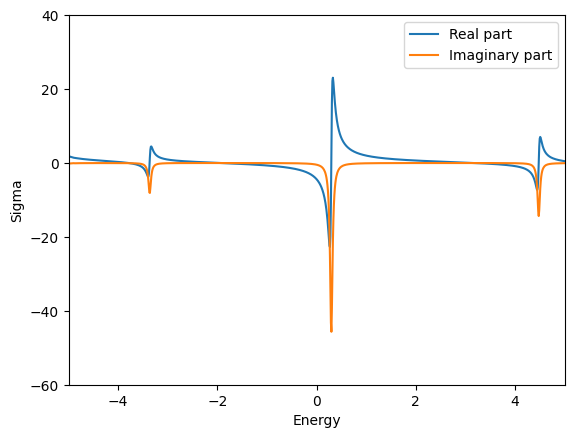

In [8]:
sigma_ret = np.load(f"{output_folder}/sigma_optimized.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-5,5)
plt.ylim(-60,40)
plt.legend()
print(sigma_ret_trace[0])
print(sigma_ret_trace[-1])

In [13]:
# energies = np.load(f"output/lowdin/dmft/non_spin/energies.npy")
# sigma_ret = sigma.retarded(energies)
# np.save(f"{output_folder}/self_energy.npy",sigma_ret)
sigma_ret = np.load(f"{output_folder}/sigma_optimized.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

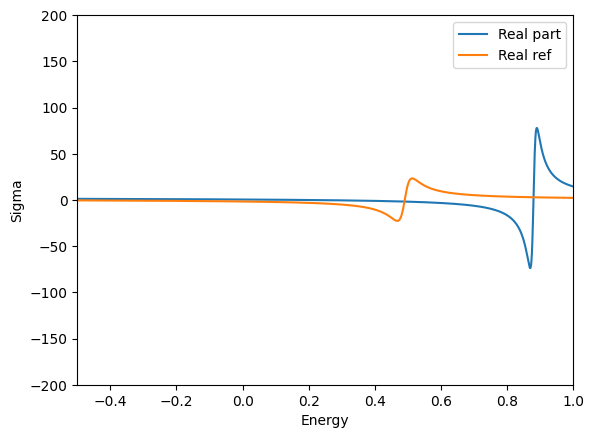

In [14]:
sig_ref = np.load("../reference/sigma_ed.npy")
sig_trace = np.trace(sig_ref, axis1=1, axis2=2)
energies_ref = np.linspace(-0.5,1, 2000)
sigma_ret = np.load(f"{output_folder}/self_energy.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)
plt.plot(energies, sigma_ret_trace.real, label="Real part")
# plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot(energies_ref,sig_trace.real, label="Real ref")
# plt.plot(energies_ref,sig_trace.imag, label="Imaginary ref")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-0.5, 1)
plt.ylim(-200,200)
plt.legend()

np.save(f"{output_folder}/trace_self_energy.npy", (energies, sigma_ret_trace))

## Disentangling local vs non-local contribution to self-energy

- Compute ED self-energy keeping only the diagonal values in V and gauge importance of non-local correlations

In [13]:
dc_diag_optimized = np.load(f"{output_folder}/ed_dcc_diag.npy")
DC = np.diag(dc_diag_optimized)
V_diag = np.diag(V.diagonal())
espace, egs = build_espace(H_eff - DC, V_diag, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC, V_diag, espace, beta, egs)


NameError: name 'gf0' is not defined

In [ ]:
sigma = Sigma( gf0, gf, H_eff, eta=eta)
sigma_ret = sigma.retarded(energies)
np.save(f"{output_folder}/sigma_optimized_diagonal_V.npy",sigma_ret)

(-4.877412663862572-9.786006538442527e-05j)
(-4.275515104853-8.752349287341477e-05j)


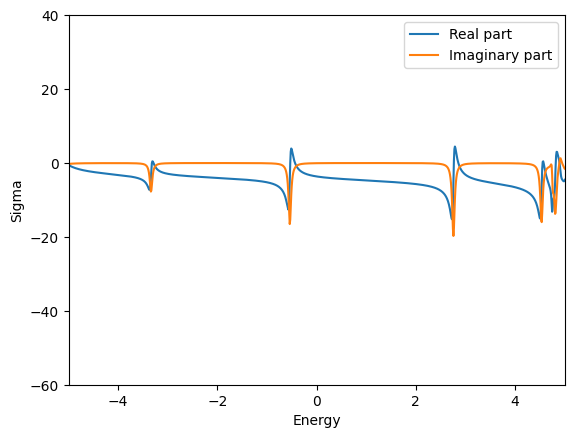

In [18]:
sigma_ret = np.load(f"{output_folder}/sigma_optimized_diagonal_V.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-5,5)
plt.ylim(-60,40)
plt.legend()
print(sigma_ret_trace[0])
print(sigma_ret_trace[-1])

In [ ]:
dc_diag_optimized = np.load(f"{output_folder}/ed_dcc_diag_V_diag.npy")
DC = np.diag(dc_diag_optimized)
V_diag = np.diag(V.diagonal())
espace, egs = build_espace(H_eff - DC, V_diag, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC, V_diag, espace, beta, egs)
sigma = Sigma( gf0, gf, H_eff, eta=eta)
sigma_ret = sigma.retarded(energies)
np.save(f"{output_folder}/sigma_optimized_diagonal_V.npy",sigma_ret)

(-0.30028427675128455-9.560278412923395e-05j)
(0.2982123919086348-8.860877198975728e-05j)


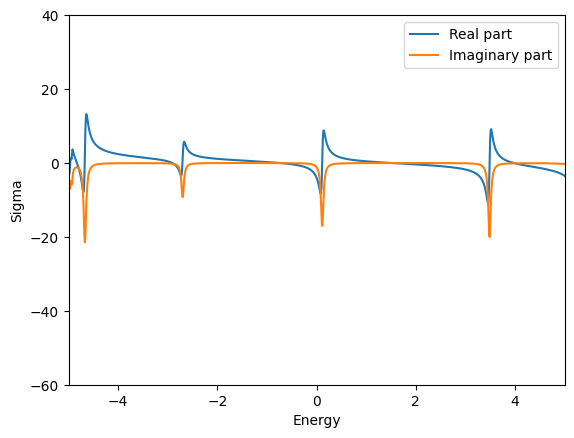

In [20]:
sigma_ret = np.load(f"{output_folder}/sigma_optimized_diagonal_V.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-5,5)
plt.ylim(-60,40)
plt.legend()
print(sigma_ret_trace[0])
print(sigma_ret_trace[-1])

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

maroon_cmap = LinearSegmentedColormap.from_list(
    "white_to_maroon",
    ["white", "#800000"],
    N=256
)

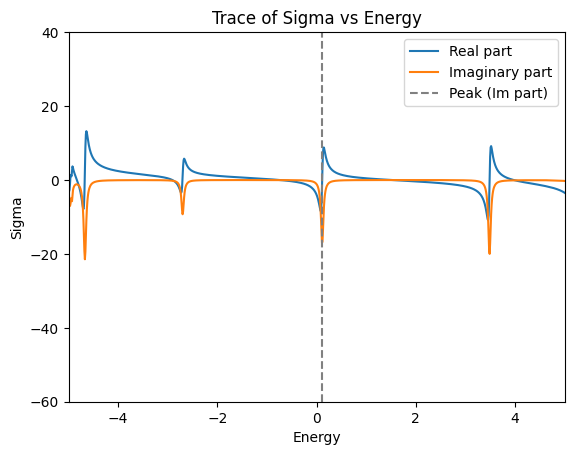

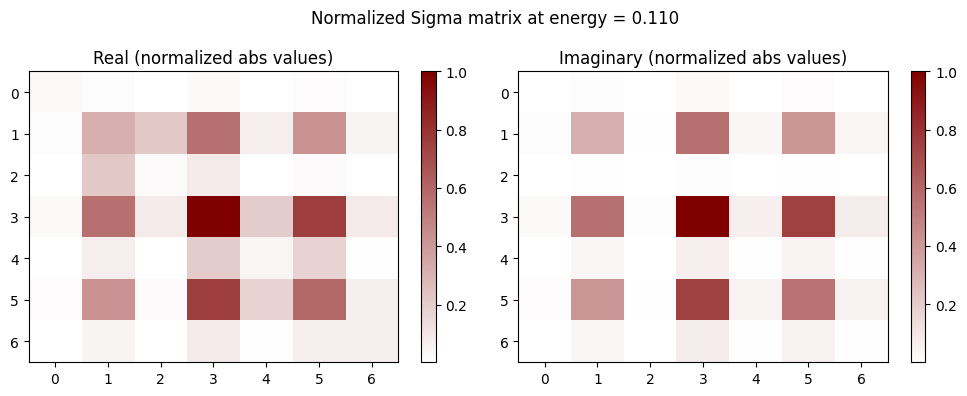

In [42]:
sigma_ret = np.load(f"{output_folder}/sigma_optimized_diagonal_V.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

energy_min = -1.0
energy_max = 1.0
energy_mask = (energies >= energy_min) & (energies <= energy_max)

imag_trace = sigma_ret_trace.imag
imag_in_window = np.where(energy_mask, imag_trace, np.inf)
peak_index = np.argmin(imag_in_window)

plt.figure()
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.axvline(x=energies[peak_index], color='gray', linestyle='--', label='Peak (Im part)')
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-5, 5)
plt.ylim(-60, 40)
plt.legend()
plt.title("Trace of Sigma vs Energy")
plt.show()

sigma_diag_V = sigma_ret[peak_index]

real_abs = np.abs(sigma_diag_V.real)
imag_abs = np.abs(sigma_diag_V.imag)

real_norm = real_abs / np.max(real_abs) if np.max(real_abs) != 0 else real_abs
imag_norm = imag_abs / np.max(imag_abs) if np.max(imag_abs) != 0 else imag_abs

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im0 = axs[0].imshow(real_norm, aspect='auto', cmap=maroon_cmap)
axs[0].set_title("Real (normalized abs values)")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(imag_norm, aspect='auto', cmap=maroon_cmap)
axs[1].set_title("Imaginary (normalized abs values)")
fig.colorbar(im1, ax=axs[1])

plt.suptitle(f"Normalized Sigma matrix at energy = {energies[peak_index]:.3f}")
plt.tight_layout()
plt.show()


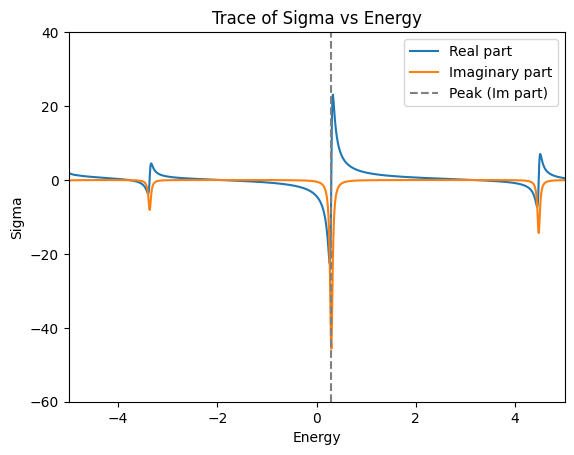

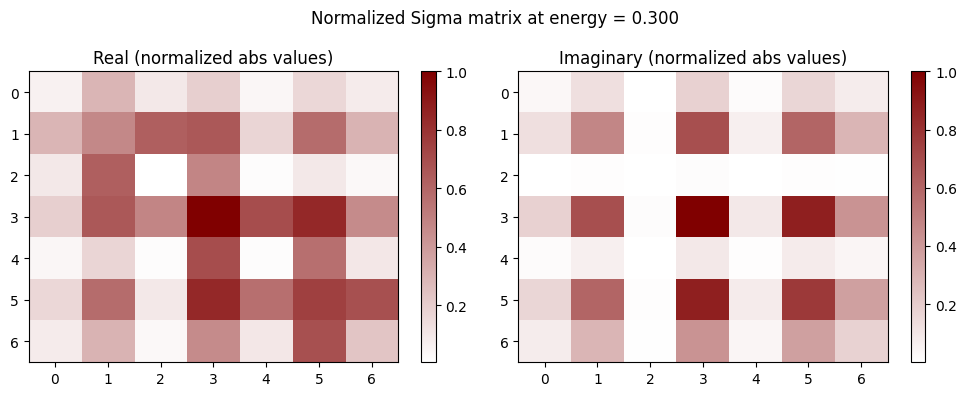

In [41]:
sigma_ret = np.load(f"{output_folder}/sigma_optimized.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

energy_min = -1.0
energy_max = 1.0
energy_mask = (energies >= energy_min) & (energies <= energy_max)

imag_trace = sigma_ret_trace.imag
imag_in_window = np.where(energy_mask, imag_trace, np.inf)
peak_index = np.argmin(imag_in_window)

plt.figure()
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.axvline(x=energies[peak_index], color='gray', linestyle='--', label='Peak (Im part)')
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-5, 5)
plt.ylim(-60, 40)
plt.legend()
plt.title("Trace of Sigma vs Energy")
plt.show()

sigma_full_V = sigma_ret[peak_index]

real_abs = np.abs(sigma_full_V.real)
imag_abs = np.abs(sigma_full_V.imag)

real_norm = real_abs / np.max(real_abs) if np.max(real_abs) != 0 else real_abs
imag_norm = imag_abs / np.max(imag_abs) if np.max(imag_abs) != 0 else imag_abs

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im0 = axs[0].imshow(real_norm, aspect='auto', cmap=maroon_cmap)
axs[0].set_title("Real (normalized abs values)")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(imag_norm, aspect='auto', cmap=maroon_cmap)
axs[1].set_title("Imaginary (normalized abs values)")
fig.colorbar(im1, ax=axs[1])

plt.suptitle(f"Normalized Sigma matrix at energy = {energies[peak_index]:.3f}")
plt.tight_layout()
plt.show()


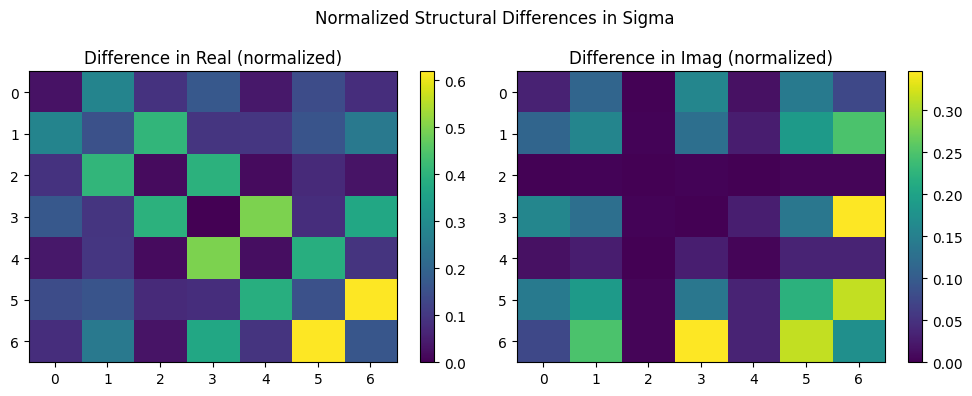

In [40]:
def normalize_abs(mat):
    return np.abs(mat) / np.max(np.abs(mat))

real_full_norm = normalize_abs(sigma_full_V.real)
real_diag_norm = normalize_abs(sigma_diag_V.real)
imag_full_norm = normalize_abs(sigma_full_V.imag)
imag_diag_norm = normalize_abs(sigma_diag_V.imag)

real_diff = np.abs(real_full_norm - real_diag_norm)
imag_diff = np.abs(imag_full_norm - imag_diag_norm)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im0 = axs[0].imshow(real_diff, cmap="viridis", aspect='auto')
axs[0].set_title("Difference in Real (normalized)")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(imag_diff, cmap="viridis", aspect='auto')
axs[1].set_title("Difference in Imag (normalized)")
fig.colorbar(im1, ax=axs[1])

plt.suptitle("Normalized Structural Differences in Sigma")
plt.tight_layout()
plt.show()


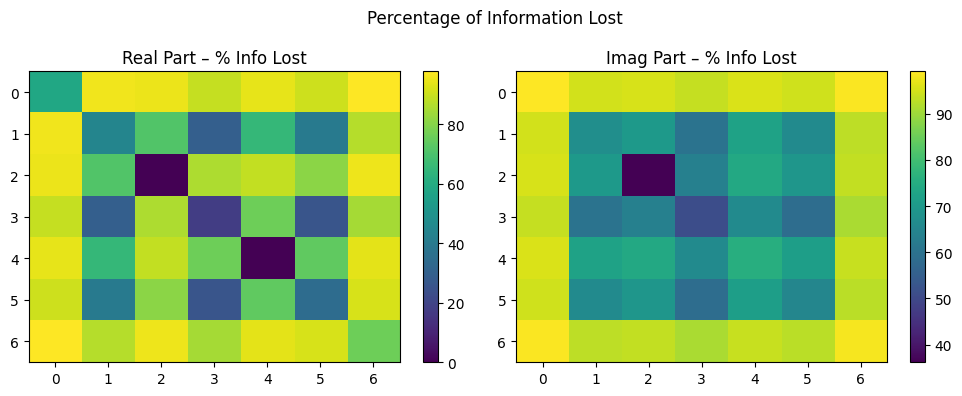

In [45]:
def percent_loss(full, diag, eps=1e-10):
    abs_full = np.abs(full)
    abs_diag = np.abs(diag)
    loss = (abs_full - abs_diag) / (abs_full + eps)
    loss *= 100
    return np.clip(loss, 0, 100)  # keep between 0 and 100%

# Compute loss for real and imaginary parts
real_loss = percent_loss(sigma_full_V.real, sigma_diag_V.real)
imag_loss = percent_loss(sigma_full_V.imag, sigma_diag_V.imag)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im0 = axs[0].imshow(real_loss, cmap="viridis", aspect='auto')
axs[0].set_title("Real Part – % Info Lost")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(imag_loss, cmap="viridis", aspect='auto')
axs[1].set_title("Imag Part – % Info Lost")
fig.colorbar(im1, ax=axs[1])

plt.suptitle("Percentage of Information Lost")
plt.tight_layout()
plt.show()


## Include non-local terms in the double-counting correction

In [31]:
# === Initial double counting with inter-orbital contributions - a simpliefied formula ===
dc0_diag = (V @ (occupancy_goal - 0.5))/ nimp
DC0 = np.diag(dc0_diag)
x0 = dc0_diag.copy()
dc0_diag

array([1.33363684, 1.24572814, 1.40886408, 1.42641018, 1.46061461,
       1.41202383, 1.53893103])

In [ ]:
espace, egs = build_espace(H_eff - DC0, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC0, V, espace, beta, egs)
sigma = Sigma(gf0,gf, H_eff, eta=eta)
sigma_ret = sigma.retarded(energies)
np.save(f"{output_folder}/sigma_abinit_non_local_dcc.npy", sigma_ret)


(3.7412963587661068-4.537394379413792e-05j)
(4.02981252018121-4.321884311865934e-05j)


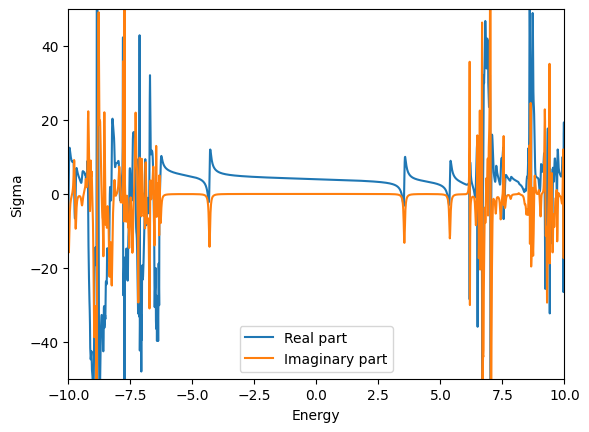

In [33]:
sigma_ret = np.load(f"{output_folder}/sigma_abinit_non_local_dcc.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-10, 10)
plt.ylim(-50,50)
plt.legend()
print(sigma_ret_trace[0])
print(sigma_ret_trace[-1])

### Optimized DCC ananlysis

In [ ]:
dc_diag_optimized = np.load(f"{output_folder}/ed_dcc_diag_non_local_dcc.npy")
DC = np.diag(dc_diag_optimized)
espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
sigma = Sigma(gf0, gf, H_eff, eta=eta)
sigma_ret = sigma.retarded(energies)
np.save(f"{output_folder}/sigma_optimized_non_local_dcc.npy",sigma_ret)


(-0.13205341859158182-4.118443566837951e-05j)
(0.12901034088264396-3.9164235740341696e-05j)


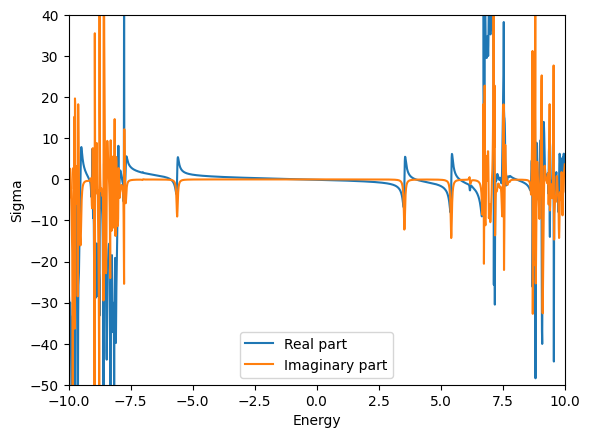

In [27]:
sigma_ret = np.load(f"{output_folder}/sigma_optimized_non_local_dcc.npy")
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-10,10)
plt.ylim(-50,40)
plt.legend()
print(sigma_ret_trace[0])
print(sigma_ret_trace[-1])